### Instalowanie pakietów

In [2]:
!pip install -U --no-cache-dir gdown==4.6.0 tensorflow-datasets --pre
!pip install -U --no-cache-dir tensorflow numpy==1.26.4 scikit-learn matplotlib==3.7.3 pillow


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for pillow from https://files.pythonhosted.org/packages/7c/18/24bff2ad716257fc03da964c5e8f05d9790a779a8895d6566e493ccf0189/pillow-11.2.1-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.7 MB 1.6 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.7 MB 4.7 MB/s eta 0:00:01
   --------------- ------------------------ 1.1/2.7 MB 6.7 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.7 MB 8.5 MB/s eta 0:00:01
   -------------------------------- ------- 2.2/2.7 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importy bibliotek

In [28]:
import os
os.environ["OMP_NUM_THREADS"] = "8"

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import os
import shutil
import random
import xml.etree.ElementTree as ET
from sklearn.metrics import classification_report
import zipfile
import os

from tensorflow import keras
from tensorflow.keras import layers, optimizers, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.19.0


### Import danych

In [30]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU wykryto i skonfigurowano:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("GPU nie wykryto - używana będzie CPU")

GPU nie wykryto - używana będzie CPU


In [31]:
folder_path = r"../data"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
os.makedirs(folder_path)

with zipfile.ZipFile("../archive.zip", 'r') as zip_ref:
    zip_ref.extractall(folder_path)

### Podgląd danych

In [32]:
train_path = "../data/train"
test_path = "../data/test"

classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

for el in classes:
    count_train = len(glob.glob(f"{train_path}/{el}/*.png"))
    count_test = len(glob.glob(f"{test_path}/{el}/*.png"))
    print(f"{el.capitalize()}: {count_test + count_train} przykładów; {count_train} treningowych, {count_test} testowych")

Angry: 4953 przykładów; 3995 treningowych, 958 testowych
Disgusted: 547 przykładów; 436 treningowych, 111 testowych
Fearful: 5121 przykładów; 4097 treningowych, 1024 testowych
Happy: 8989 przykładów; 7215 treningowych, 1774 testowych
Neutral: 6198 przykładów; 4965 treningowych, 1233 testowych
Sad: 6077 przykładów; 4830 treningowych, 1247 testowych
Surprised: 4002 przykładów; 3171 treningowych, 831 testowych


### Dodanie augmentacji

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [34]:
CELLS_1 = 512
CELLS_2 = 128
LEARNING_RATE = 1e-3
EPOCHS = 50

BATCH_SIZE = 64
IMAGE_HIGHT =48
IMAGE_WIDTH = 48
IMAGE_SIZE = (IMAGE_HIGHT, IMAGE_WIDTH)
INPUT_SHAPE = (IMAGE_HIGHT, IMAGE_WIDTH, 1)

CLASS_COUNT = 7

In [35]:
train_ds = image_dataset_from_directory(
    'data/train',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
)

Found 28709 files belonging to 7 classes.


In [36]:
val_ds = image_dataset_from_directory(
    'data/test',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 7178 files belonging to 7 classes.


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))

model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(CELLS_1, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(CELLS_2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.3)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,767,367 (37.26 MB)

 Trainable params: 9,765,319 (37.25 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
history = model.fit(x=train_ds,
                    batch_size = BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 171s 375ms/step - accuracy: 0.2508 - loss: 2.3466 - val_accuracy: 0.3208 - val_loss: 1.6947
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 150s 335ms/step - accuracy: 0.4167 - loss: 1.5310 - val_accuracy: 0.4678 - val_loss: 1.3917
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4986 - loss: 1.3268

In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

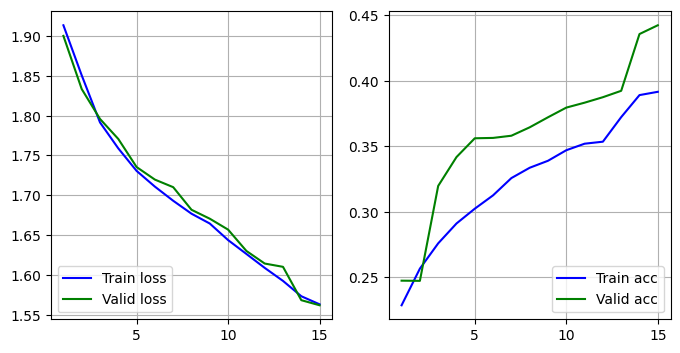

In [22]:
def plot_train_valid_history(history):
    epochs = np.arange(len(history.history['val_loss'])) + 1
    fig = plt.figure(figsize=(8, 4))
    if 'accuracy' in history.history:
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left')
        plt.grid(True)

        ax1 = fig.add_subplot(122)
        ax1.plot(epochs, history.history['accuracy'], c='b', label='Train acc')
        ax1.plot(epochs, history.history['val_accuracy'], c='g', label='Valid acc')
        plt.legend(loc='lower right')
        plt.grid(True)


    else:
        ax1 = fig.add_subplot(111)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left')
        plt.grid(True)
    plt.show()


plot_train_valid_history(history)

In [24]:
model.save("model/emotion_model_v3.keras")